# Exploratory Analysis
## Getting my hands dirty

On this notebook I will investigate the data provided in order to analyze anomalies and present the best approach for the seccond part of the challenge, first lets:

- Load the data
- Set interest dates (today, yesterday and historical average)
- Separate the date for dates
- group by hour
- Join the tables by hour
- Verify the results

In [36]:
import pandas as pd

df_status = pd.read_csv("../data/transactions.csv", parse_dates=["timestamp"])
df_status["hour_only"] = df_status["timestamp"].dt.hour
df_status["date_only"] = df_status["timestamp"].dt.date

today_date = pd.to_datetime("2025-07-15").date()
yesterday_date = pd.to_datetime("2025-07-14").date()
historical_dates = [pd.to_datetime("2025-07-12").date(), pd.to_datetime("2025-07-13").date()] # Corrected here

approved_today = df_status[(df_status["date_only"] == today_date) & (df_status["status"] == "approved")]
approved_yesterday = df_status[(df_status["date_only"] == yesterday_date) & (df_status["status"] == "approved")]
approved_history = df_status[(df_status["date_only"].isin(historical_dates)) & (df_status["status"] == "approved")]

today_group = approved_today.groupby("hour_only")["count"].sum().reset_index(name="today")
yesterday_group = approved_yesterday.groupby("hour_only")["count"].sum().reset_index(name="yesterday")

hourly_sum_history = approved_history.groupby(["date_only", "hour_only"])["count"].sum().reset_index()

history_group = hourly_sum_history.groupby("hour_only")["count"].mean().reset_index(name="historical_avg")

df_compare = pd.merge(today_group, yesterday_group, on="hour_only", how="outer")
df_compare = pd.merge(df_compare, history_group, on="hour_only", how="outer")
df_compare = df_compare.sort_values("hour_only").fillna(0)
df_compare.rename(columns={"hour_only": "hour"}, inplace=True)

# Exibir a tabela de comparação
display(df_compare)

,hour,today,yesterday,historical_avg
0,0,7143.0,7174,6964.0
1,1,7152.0,7211,6652.0
2,2,7176.0,7215,7180.0
3,3,6109.0,6513,7203.0
4,4,6902.0,5782,7120.0
5,5,7242.0,6937,7237.0
6,6,7144.0,7246,7197.0
7,7,7257.0,7243,7181.0
8,8,7303.0,7297,6567.0
9,9,7277.0,6985,6434.0


# Anomaly detected

Today's transaction was in according with yesterday and the historical average until 13hrs when It suddently dropped to 0 and remained like this.

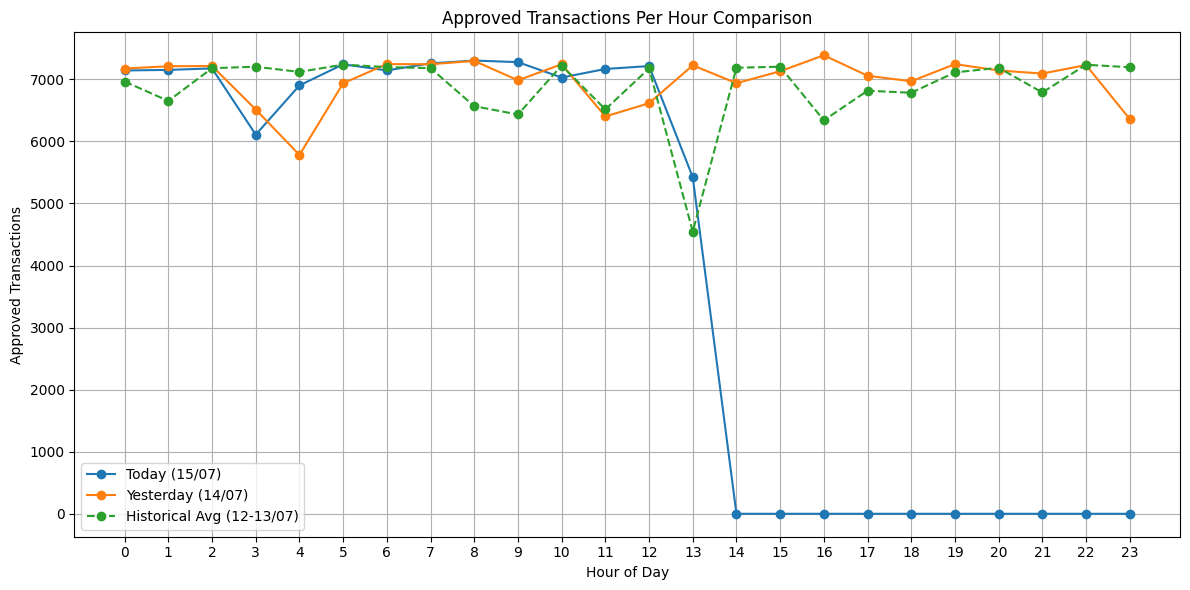

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_compare["hour"], df_compare["today"], label="Today (15/07)", marker="o")
plt.plot(df_compare["hour"], df_compare["yesterday"], label="Yesterday (14/07)", marker="o")
plt.plot(df_compare["hour"], df_compare["historical_avg"], label="Historical Avg (12-13/07)", linestyle="--", marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Approved Transactions")
plt.title("Approved Transactions Per Hour Comparison")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

Now we will investigate the failed and denied transactions to verify if we can find anything in common in that timeframe

In [28]:
import pandas as pd

# Carregar os dados
df_status = pd.read_csv("../data/transactions.csv", parse_dates=["timestamp"])
df_status["hour_only"] = df_status["timestamp"].dt.hour
df_status["date_only"] = df_status["timestamp"].dt.date

# Definir a data de interesse
today_date = pd.to_datetime("2025-07-15").date()

# Filtrar transações para o dia 15 de julho E horas a partir das 13h
transactions_after_13h = df_status[
    (df_status["date_only"] == today_date) &
    (df_status["hour_only"] >= 13)
]

num_transactions_after_13h = len(transactions_after_13h)

print(f"Total number of transactions registred from 13:00 of {today_date}: {num_transactions_after_13h}")

if num_transactions_after_13h == 0:
    print("\nConfirmação: Não há registros de transações (de qualquer status) a partir das 13:00 do dia 15 de julho.")
    print("Isso sugere que o problema está na entrada de dados ou no sistema de coleta.")
else:
    print(f"\nThere is {num_transactions_after_13h} transactions registered after 13:00.")
    display(df_status.tail(25))


Total number of transactions registred from 13:00 of 2025-07-15: 270

There is 270 transactions registered after 13:00.


,timestamp,status,count,hour_only,date_only
25895,2025-07-15 13:20:00,refunded,1,13,2025-07-15
25896,2025-07-15 13:21:00,refunded,1,13,2025-07-15
25897,2025-07-15 13:22:00,refunded,2,13,2025-07-15
25898,2025-07-15 13:23:00,refunded,0,13,2025-07-15
25899,2025-07-15 13:24:00,refunded,0,13,2025-07-15
25900,2025-07-15 13:25:00,refunded,1,13,2025-07-15
25901,2025-07-15 13:26:00,refunded,3,13,2025-07-15
25902,2025-07-15 13:27:00,refunded,3,13,2025-07-15
25903,2025-07-15 13:28:00,refunded,1,13,2025-07-15
25904,2025-07-15 13:29:00,refunded,0,13,2025-07-15


We noticed that the last 25 transactions before completely stopping where refund, lets verify the refund status ocurrency on the day 15

In [32]:
import pandas as pd

# Carregar os dados
df_status = pd.read_csv("../data/transactions.csv", parse_dates=["timestamp"])
df_status["hour_only"] = df_status["timestamp"].dt.hour
df_status["date_only"] = df_status["timestamp"].dt.date

# Definir a data de interesse (15 de julho de 2025)
today_date = pd.to_datetime("2025-07-15").date()

# Filtrar o DataFrame para transações apenas do dia 15 de julho
transactions_on_today_date = df_status[df_status["date_only"] == today_date].copy()

# Encontrar o índice da primeira ocorrência de 'refunded' (ortografia corrigida)
# dentro das transações do dia 15 de julho
# Adicionamos uma verificação para garantir que o DataFrame não esteja vazio antes de tentar acessar index[0]
if not transactions_on_today_date[transactions_on_today_date['status'].str.lower() == 'refunded'].empty:
    idx_in_filtered_df = transactions_on_today_date[transactions_on_today_date['status'].str.lower() == 'refunded'].index[0]

    # Pega essa linha e as 20 seguintes do DataFrame ORIGINAL, usando o índice original
    # Para isso, precisamos do índice original da linha no df_status completo
    # O .loc[idx_in_filtered_df] nos dá a linha completa do df_status original
    # e então pegamos as 20 seguintes a partir do índice original dela.
    original_idx = transactions_on_today_date.loc[idx_in_filtered_df].name
    resultado = df_status.iloc[original_idx : original_idx + 21]

    print(f"Primeira ocorrência de 'refunded' no dia {today_date} e as 20 linhas subsequentes:")
    display(resultado)
else:
    print(f"Não foram encontradas transações com status 'refunded' no dia {today_date}.")


Primeira ocorrência de 'refunded' no dia 2025-07-15 e as 20 linhas subsequentes:


,timestamp,status,count,hour_only,date_only
25095,2025-07-15 00:00:00,refunded,1,0,2025-07-15
25096,2025-07-15 00:01:00,refunded,3,0,2025-07-15
25097,2025-07-15 00:02:00,refunded,3,0,2025-07-15
25098,2025-07-15 00:03:00,refunded,1,0,2025-07-15
25099,2025-07-15 00:04:00,refunded,2,0,2025-07-15
25100,2025-07-15 00:05:00,refunded,1,0,2025-07-15
25101,2025-07-15 00:06:00,refunded,2,0,2025-07-15
25102,2025-07-15 00:07:00,refunded,3,0,2025-07-15
25103,2025-07-15 00:08:00,refunded,1,0,2025-07-15
25104,2025-07-15 00:09:00,refunded,3,0,2025-07-15


After the first ocourrency of the refunded status all subsequent where also refunded, this is a trigger indicator, let's verify it in a graph

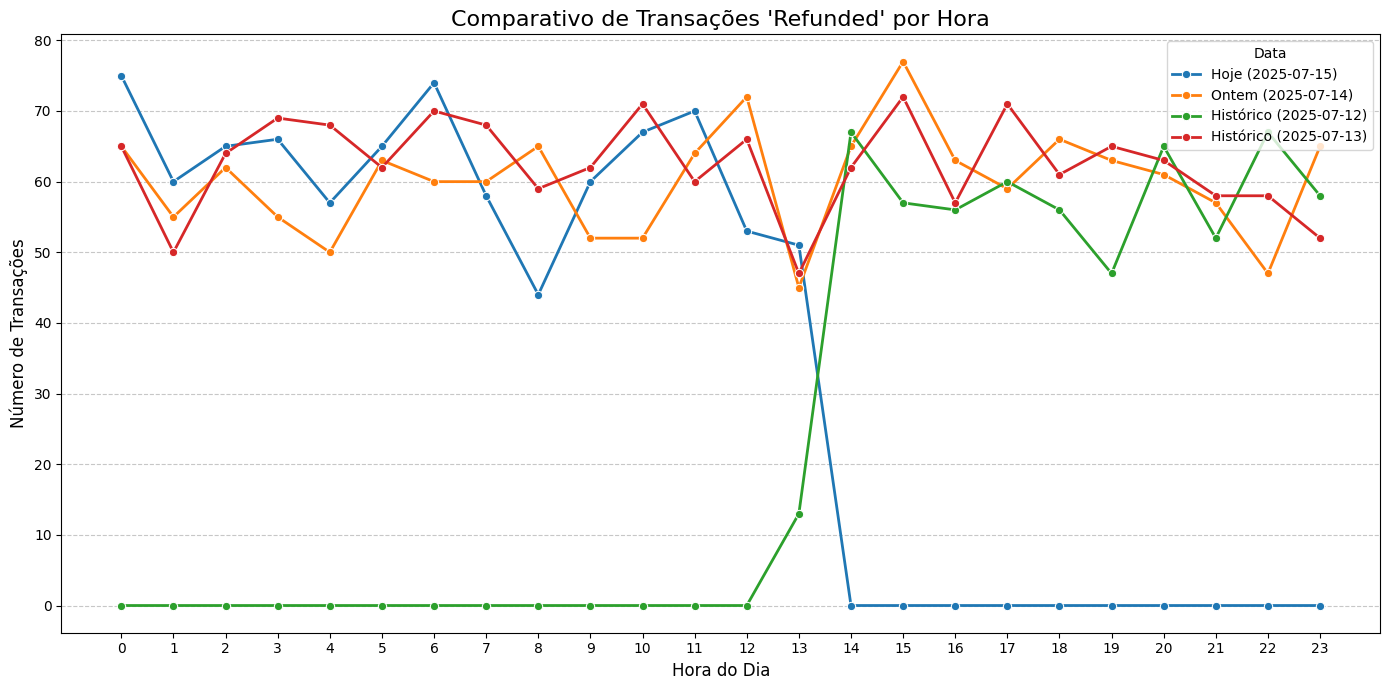

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados e preparar colunas de data e hora
df_status = pd.read_csv("../data/transactions.csv", parse_dates=["timestamp"])
df_status["date_only"] = df_status["timestamp"].dt.date
df_status["hour_only"] = df_status["timestamp"].dt.hour
df_status["status"] = df_status["status"].str.lower()  # padronizar

# Datas de interesse
today_date = pd.to_datetime("2025-07-15").date()
yesterday_date = pd.to_datetime("2025-07-14").date()
historical_dates = [pd.to_datetime("2025-07-12").date(), pd.to_datetime("2025-07-13").date()]

# Função para agrupar 'refunded' por hora com label
def get_hourly_refunded(df, date, label):
    filtered = df[(df["date_only"] == date) & (df["status"] == "refunded")]
    hourly = filtered.groupby("hour_only")["count"].sum().reset_index()
    all_hours = pd.DataFrame({'hour_only': range(0, 24)})
    hourly = pd.merge(all_hours, hourly, on='hour_only', how='left').fillna(0)
    hourly["label"] = label
    return hourly

# Gerar dados para cada dia
df_plot = pd.concat([
    get_hourly_refunded(df_status, today_date, f"Hoje ({today_date})"),
    get_hourly_refunded(df_status, yesterday_date, f"Ontem ({yesterday_date})"),
    *[get_hourly_refunded(df_status, d, f"Histórico ({d})") for d in historical_dates]
])

# Plotar
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_plot,
    x="hour_only",
    y="count",
    hue="label",
    marker="o",
    linewidth=2
)

plt.title("Comparativo de Transações 'Refunded' por Hora", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=12)
plt.ylabel("Número de Transações", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Data", loc="upper right")
plt.tight_layout()
plt.show()